In [1]:
import numpy as np
from scipy.sparse import csr_matrix
np.random.seed(1702) 

In [2]:
#Load in the large data file and inspect the data 
data = np.load('user_movie_rating.npy')
print(data.shape)
print(data)

(65225506, 3)
[[     1     30      3]
 [     1    157      3]
 [     1    173      4]
 ...
 [103703  17622      2]
 [103703  17627      4]
 [103703  17764      4]]


In [3]:
#Split the data into three lists of ratings, movies and users respectively. 
user_ids_full = data[:,0]
movie_ids_full = data[:,1]
ratings_full = data[:,2]

# creating sparse matrices 
sparse_rowMatrix_full = csr_matrix((ratings_full, (movie_ids_full, user_ids_full)))

#Remove the first column of the sparse row matrix, since it adds a column too many 
sparse_rowMatrix_full = sparse_rowMatrix_full[:,1:]
#Check the amount of users
print("Number of selected users with user_ids_full is: ", np.shape(sparse_rowMatrix_full[0,:])[1])

Number of selected users with user_ids_full is:  103703


In [4]:
np.random.seed(1702) 
"""
This block creates a signature matrix for the data 
"""

m = 0.1 #fraction of rows that we want to pick a random permutation from. According to the book (top of page 88), the
         #resulting signature matrix should still be valid. This also increases speed of the calculation of the signature matrix 
         #by a factor 1/m, which helps a lot. 

def minhashing(data_matrix,row_fraction,num_permutations):
    
    print("Original (sparse) Matrix:\n", data_matrix, "with shape:", data_matrix.shape)
    
    #make an empty (zeros) matrix for the 100 random permutations
    random_perm_matrix = np.zeros((data_matrix.shape[0], num_permutations)) 
    random_perm = np.arange(data_matrix.shape[0])
    for i in range(num_permutations):
        #Make 100 random permutations of the columns, and place them into the random permutation matrix
        np.random.shuffle(random_perm)
        random_perm_matrix[:,i] = random_perm
    print('The random matrix is\n',random_perm_matrix, "with shape:", random_perm_matrix.shape)
    

    signatureMatrix = np.full((random_perm_matrix.shape[1], data_matrix.shape[1]), np.inf)
    #make the signature matrix, which is initially filled with only inf-values
    print("\nSignature Matrix:\n", signatureMatrix, "with shape:", signatureMatrix.shape)
    
    for r in range(0, int(row_fraction*data_matrix.shape[0])): #row
        #print("Row:", r)
        random_perm_matrix_row = random_perm_matrix[r]
            
        #We first get the relevant row of the data, and then only loop over the non-zero elements! 
        data_matrix_row = data_matrix.getrow(r)
        data_col_indices = data_matrix_row.indices #indices of the non-zero elements
        
        #Loop over the non-zero elements
        for idx in data_col_indices:
            signatureMatrix[:,idx] = np.minimum(signatureMatrix[:,idx],random_perm_matrix_row)              

    print("\nSignature Matrix:\n", signatureMatrix)
    
    return np.array(signatureMatrix,dtype=np.int16)

S = minhashing(sparse_rowMatrix_full,m,360) #S is the resulting signature matrix

Original (sparse) Matrix:
   (1, 94)	3
  (1, 154)	4
  (1, 440)	3
  (1, 574)	4
  (1, 852)	4
  (1, 1188)	5
  (1, 1214)	4
  (1, 1263)	4
  (1, 1498)	3
  (1, 1716)	3
  (1, 1717)	3
  (1, 1802)	5
  (1, 2180)	3
  (1, 2325)	2
  (1, 2680)	3
  (1, 3399)	2
  (1, 3669)	5
  (1, 3689)	4
  (1, 3880)	5
  (1, 4755)	4
  (1, 4798)	1
  (1, 5267)	4
  (1, 5690)	3
  (1, 5883)	5
  (1, 6741)	4
  :	:
  (17770, 100303)	2
  (17770, 100390)	3
  (17770, 100506)	3
  (17770, 100559)	2
  (17770, 100609)	3
  (17770, 100663)	3
  (17770, 100665)	3
  (17770, 100700)	2
  (17770, 100719)	3
  (17770, 100730)	3
  (17770, 100763)	4
  (17770, 101075)	3
  (17770, 101297)	3
  (17770, 101858)	3
  (17770, 101922)	2
  (17770, 102016)	3
  (17770, 102036)	3
  (17770, 102106)	1
  (17770, 102255)	3
  (17770, 102579)	4
  (17770, 103054)	3
  (17770, 103107)	3
  (17770, 103343)	4
  (17770, 103381)	3
  (17770, 103441)	3 with shape: (17771, 103703)
The random matrix is
 [[ 9437.  9144.  7231. ...  4232.  2180.  6142.]
 [ 7703.   235. 15416. .

In [6]:
print("The signature matrix has shape",np.shape(S))
b = 40 #number of bands
r = 9 #number of rows per band

def split_vector(signature, b, r):
    # code splitting signature in b parts
    subvecs = []
    for i in range(0, S.shape[0],r):
        subvecs.append(signature[i : i+r])
    return np.array(subvecs,dtype=np.int32)

split_S = split_vector(S, b, r)
dim_bandedMatrix = np.shape(split_S)
print('The signature matrix split into bands has shape',dim_bandedMatrix)
bandsTotal = dim_bandedMatrix[0]*dim_bandedMatrix[2]
usersTotal = dim_bandedMatrix[2]
bands_per_user = dim_bandedMatrix[0]

#Function to generate a random hash function
def generate_hash_function(size, total_users):
    a = np.random.randint(1, 1000, size)
    b = np.random.randint(1, 1000, size)
    return lambda x: tuple((a * x + b) % total_users)

#Hash function for each band
hash_functions = [generate_hash_function(r, usersTotal) for _ in range(b)]

#Hashing the bands to various buckets 
hash_table = {}
hash_counter = 0 
candidate_pairs = []
#for u in range(usersTotal): #use this preferably, too slow now though 
for u in range(usersTotal):  # Iterate over all users
    for band_idx in range(b):
        current_band = split_S[band_idx, :, u]

        # Apply the hash function to the band
        hashed_value = hash_functions[band_idx](tuple(current_band))

        if hashed_value not in hash_table:
            hash_table[hashed_value] = [(u, band_idx)]
        else:
            for stored_pair in hash_table[hashed_value]:
                stored_u, stored_band_idx = stored_pair
                if np.array_equal(current_band, split_S[stored_band_idx, :, stored_u]):
                    candidate_pairs.append((u, stored_u))
                    hash_counter += 1

            # Add the current pair to the hash table
            hash_table[hashed_value].append((u, band_idx))

candidate_pairs = np.array(candidate_pairs)
print('The number of candidate pairs found is:',np.shape(candidate_pairs)[0])

The signature matrix has shape (360, 103703)
The signature matrix split into bands has shape (40, 9, 103703)
The number of candidate pairs found is: 318567


In [7]:
def jaccard_similarity(candidate_pairs,data=sparse_rowMatrix_full):
    #In this function we use numpy to vectorize the Jaccard Similarity calculations for all candidate pairs
    #Using numpy drastically improves the efficiency of the code
    #The memory cost of converting sparse row matrices with datatype int64 costs a lot of RAM, so for that reason we convert the dtype to int8 first 
    users1 = data[:,candidate_pairs[:,0]].astype(np.int8).toarray()
    users2 = data[:,candidate_pairs[:,1]].astype(np.int8).toarray()

    one_gave_rating = np.logical_and(users1,users2) #The logical AND operator represents the intersection
    both_gave_rating = np.logical_or(users1,users2) #The logical OR operator represents the union 

    num_pairs = len(candidate_pairs[:,0])
    simPairs = []
    simPairs_value = []
    for i in range(num_pairs):
        nom = np.sum(one_gave_rating[:,i])
        denom = np.sum(both_gave_rating[:,i])
        total = nom/denom
        if total > 0.5:
            simPairs.append(candidate_pairs[i].tolist())
            simPairs_value.append(total)
    print('Accepted user pairs: \n',simPairs)
    print('Jaccard Similarity value: \n',simPairs_value)
    print('Number of similar user pairs:',len(simPairs_value))
    return simPairs,simPairs_value

import timeit
begin = timeit.default_timer()
accepted_userPairs,JS_value = jaccard_similarity(candidate_pairs)
end = timeit.default_timer() - begin
print('this took {:.2f} seconds'.format(end))

this took 317.19 seconds
[[16193, 10582], [18381, 9017], [18866, 16193], [29806, 413], [29806, 15038], [30250, 28633], [33145, 18866], [33366, 15038], [33755, 3583], [33755, 8295], [35418, 15161], [35418, 32305], [35418, 20676], [36382, 6876], [36382, 6876], [36824, 7623], [36824, 9017], [38030, 26478], [42740, 5352], [46364, 413], [46364, 413], [46364, 413], [46936, 33755], [47929, 32305], [47929, 15161], [47929, 33755], [49458, 8295], [49458, 25620], [51236, 15161], [51236, 33755], [52431, 51236], [53266, 15161], [53266, 35418], [53266, 10611], [54719, 33755], [55032, 30524], [55104, 9771], [58327, 53266], [58327, 7623], [58327, 31818], [58327, 38030], [58327, 2740], [58750, 7529], [61540, 9017], [61933, 18866], [61933, 33145], [63688, 20163], [63688, 20163], [63973, 47112], [63973, 33755], [63973, 49458], [66309, 36824], [66679, 30250], [68130, 33755], [68130, 37358], [73537, 47112], [73537, 33755], [73537, 44550], [73959, 63989], [74190, 20443], [74190, 46364], [74190, 58327], [741

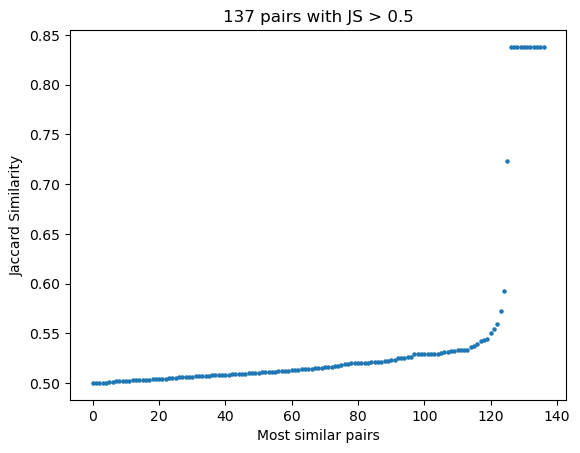

In [9]:
#This part is dedicated to plotting the similar users with a Jaccard Similarity above 0.5, with ascending order 

import matplotlib.pyplot as plt

plt.scatter(np.arange(len(testo3)),np.sort(testo3),s=5)
plt.xlabel('Most similar pairs')
plt.ylabel('Jaccard Similarity')
plt.title('{} pairs with JS > 0.5'.format(len(testo3)))
plt.show()

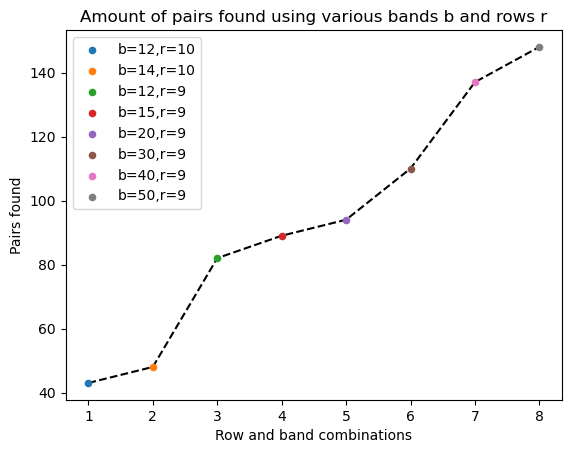

In [10]:
#This code block will be for creating a plot using various values for the bands b and rows r to visualise how many pairs we found 

band_row_combinations = ['b=12,r=10','b=14,r=10','b=12,r=9','b=15,r=9','b=20,r=9','b=30,r=9','b=40,r=9','b=50,r=9']
pairs_found = [43,48,82,89,94,110,137,148]

for i in range(len(pairs_found)):
    plt.scatter(i+1,pairs_found[i],s=20,zorder=20,label=band_row_combinations[i])
plt.plot(np.arange(1,len(pairs_found)+1,1),pairs_found,color='black',linestyle='--',zorder=1)
plt.xlabel('Row and band combinations')
plt.ylabel('Pairs found')
plt.title('Amount of pairs found using various bands b and rows r')
plt.legend(loc='upper left')
plt.show()

In [7]:
#This is faster, but using a loop ensures we at least print some users if something goes wrong. 

def jaccard_similarity_alt(candidate_pairs,data=sparse_rowMatrix_full):
    #In this function we use numpy to vectorize the Jaccard Similarity calculations for all candidate pairs
    #Using numpy drastically improves the efficiency of the code
    #The memory cost of converting sparse row matrices with datatype int64 costs a lot of RAM, so for that reason we convert the dtype to int8 first 
    users1 = data[:,candidate_pairs[:,0]].astype(np.int8).toarray()
    users2 = data[:,candidate_pairs[:,1]].astype(np.int8).toarray()

    both_gave_rating = np.logical_and(users1,users2) #The logical AND operator represents the intersection
    one_gave_rating = np.logical_or(users1,users2) #The logical OR operator represents the union 

    nom = np.sum(both_gave_rating,axis=0)
    denom = np.sum(one_gave_rating,axis=0)
    total = nom/denom 

    above_threshold = np.where(total > 0.5)
    simPairs = candidate_pairs[above_threshold]
    simPairs_value = total[above_threshold]
    print('Accepted user pairs: \n',simPairs)
    print('Jaccard Similarity value: \n',simPairs_value)
    return simPairs,simPairs_value

import timeit
begin = timeit.default_timer()
accepted_pairs,jacc_values = jaccard_similarity_alt(candidate_pairs)
end = timeit.default_timer() - begin
print('this took {:.2f} seconds'.format(end))
print(accepted_pairs)
print(jacc_values)
print(len(jacc_values))



Accepted user pairs: 
 [[ 16193  10582]
 [ 18381   9017]
 [ 18381   9017]
 [ 18866  16193]
 [ 29806    413]
 [ 29806  15038]
 [ 30250  28633]
 [ 33145  18866]
 [ 33145   7848]
 [ 33366  15038]
 [ 33755   3583]
 [ 33755   8295]
 [ 35418  15161]
 [ 35418  32305]
 [ 35418  20676]
 [ 36382   6876]
 [ 36382   6876]
 [ 36824   7623]
 [ 36824   9017]
 [ 38030  26478]
 [ 40859  18692]
 [ 42740   5352]
 [ 46364    413]
 [ 46364    413]
 [ 46364    413]
 [ 46936  33755]
 [ 47929  32305]
 [ 47929  15161]
 [ 47929  33755]
 [ 49458   8295]
 [ 49458  25620]
 [ 50546  35418]
 [ 51236  15161]
 [ 51236  33755]
 [ 52431  51236]
 [ 53266  15161]
 [ 53266  35418]
 [ 53266  10611]
 [ 54719  33755]
 [ 55032  30524]
 [ 55104   9771]
 [ 58327  53266]
 [ 58327   7623]
 [ 58327  31818]
 [ 58327  38030]
 [ 58327   2740]
 [ 58750   7529]
 [ 61540   9017]
 [ 61933  18866]
 [ 61933  33145]
 [ 63688  20163]
 [ 63688  20163]
 [ 63973  47112]
 [ 63973  33755]
 [ 63973  49458]
 [ 66309  36824]
 [ 66679  30250]
 [ 68130